In [2]:
import PIL
from PIL import Image
import glob
import shutil, os
from time import sleep
import cv2
import numpy as np

## Find the contours of the picture to get the number.
Note: detection mode - 
1. **cv2.RETR_EXTERNAL: only detect the outer edge of the outline**
2. cv2.RETR_LIST: No hierarchical relationship is established when detecting contours
3. cv2.RETR_CCOMP: Established two hierarchical relationships when detecting contours
4. cv2.RETR_TREE: Establish a tree-like hierarchical relationship when detecting contours
Algorithm used for countour - 
1. cv2.CHAIN_APPROX_NONE: store all contour points
2. **cv2.CHAIN_APPROX_SIMPLE: compress horizontal, vertical and diagonal elements, and only store the end points in the direction. (For example: rectangle only store four points)**

- Most important function:
cv2.findContours('image', detectionMode, algorithm) -> return (countour information, ??)

- To find the point in the image:
(x,y,w,h) = cv2.boundingRect(contuors(0))

- From analysis, we can see in the picture: 
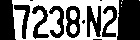
1. the noise points are usually very small, and the height will below 28. We can removed these noise point by using this proporties

In [3]:
image = cv2.imread('7238N2.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # turn gray
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV) # turn to black white
contours1 = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours1[0]
letter_image_regions = [] # this array is used to store all the point that is detected

count = 0 # this is for checking purpose, we know a car plate should have 6 numbers.
wmax = 26

# this part is check for the wmax (width max)
for box in letter_image_regions:
    x, y, w, h = box
    # we assume the letter is inside the region x = 2-125, w = 5-26, h = 20 - 40
    if x >= 2 and x <= 125 and w >= 5 and w <= 26 and h >= 20 and h < 40:
        count += 1 
        
if not(count == 6): # we add the width since maybe there is two number links together
    wmax = 35
    
# crop the number 
nChar = 0 
letterlist = [] 
for box in letter_image_regions:  
    x, y, w, h = box        
    # we assume the letter is inside the region x = 2-125, w = 5-wmax, h = 20 - 40
    if x>=2 and x<=125 and w>=5 and w<=wmax and h>=20 and h<40:
        nChar +=1 
        letterlist.append((x, y, w, h))

## remove the noise
- Let's see what we will obtain after thresh:
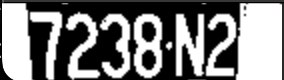

- After observing the image, it's apparent that there is still some unwanted noise present between the characters '8' and 'N'. To address this issue, we employ the thresholded image ('thresh') to eliminate the noise. We achieve this by examining each white pixel in the image and assessing its surroundings. If the number of neighboring white pixels is less than or equal to six, we classify the pixel as noise. Below figure shows how it works
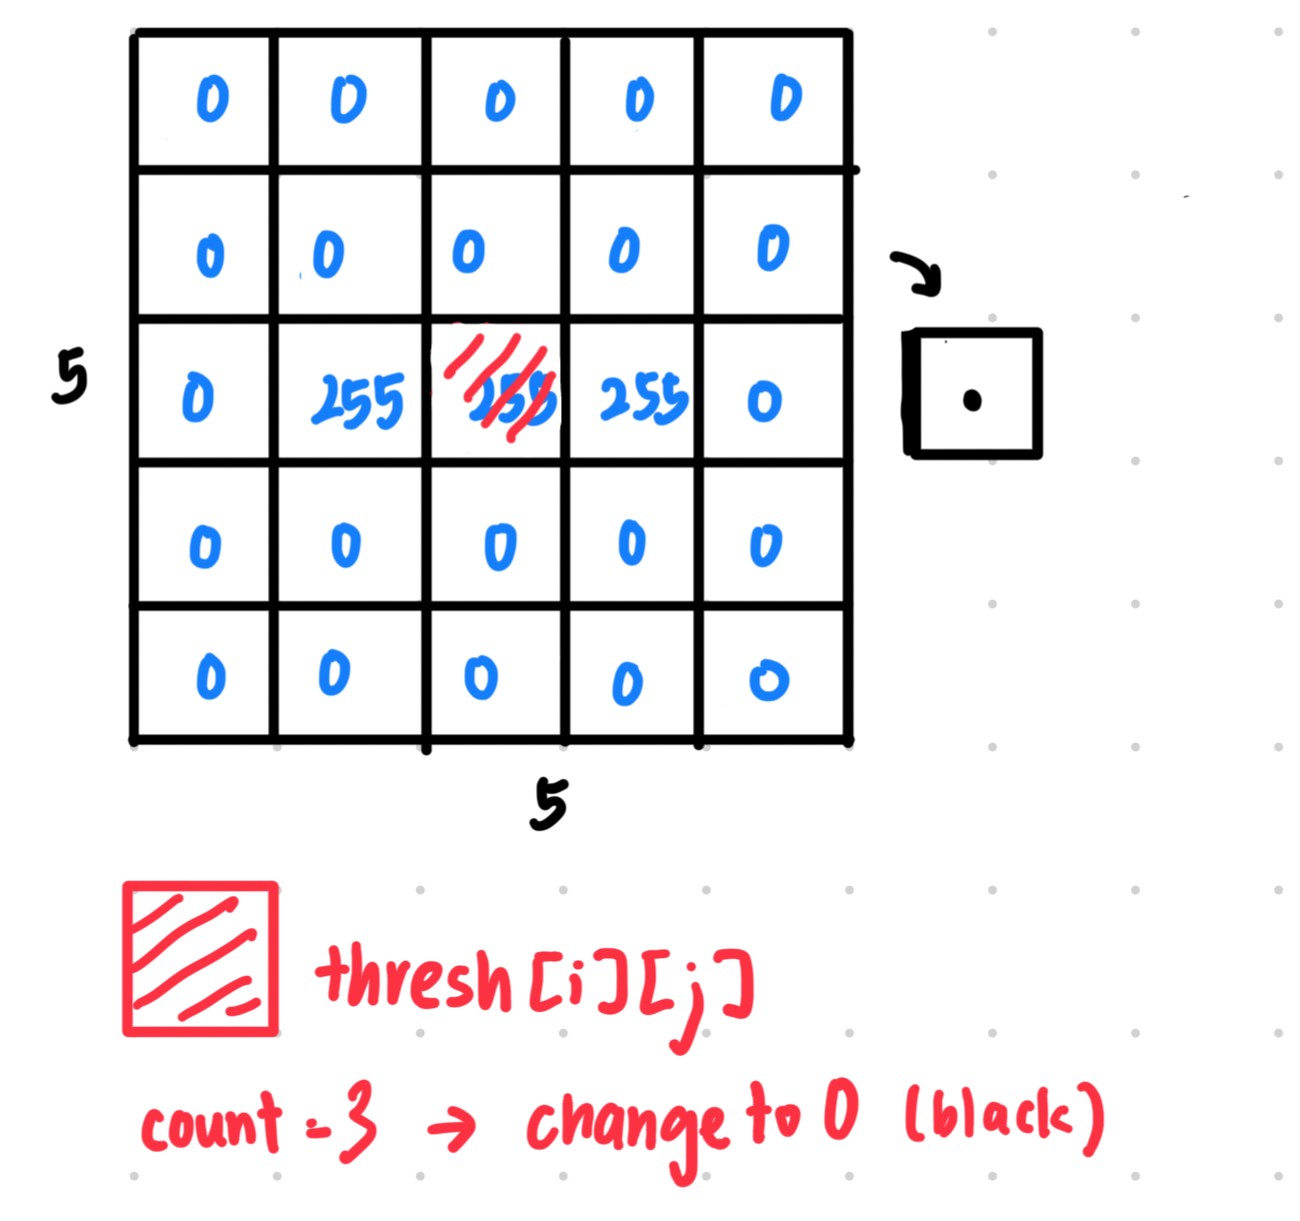

In [4]:
for i in range(len(thresh)):
    for j in range(len(thresh[1])): # height
        if thresh[i][j] == 255:     # if the point is white
            count = 0 
            for k in range(-2, 3):
                for l in range(-2, 3):
                    try:
                        if thresh[i + k][j + l] == 255: # if it is white
                            count += 1
                    except IndexError:
                        pass
            if count <= 6:  # less than 6 white region
                thresh[i][j] = 0  # remove the white region

## Remove abnormal ground
Let's look at the picture again: 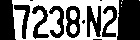
- you can see there is a black color region on the left hand side, and when we crop the image (inside cropMono), there is still a small black region included. Here, we use the technique of lifearea (the biggest white region) to exclude the abnormal ground. The area function is a function that use to calculate the whole white area. 
- then we find the maximum life area, other area we will just exclude it (change the bg number)
- for more explanation, look ate Life.ipynb file.

In [5]:
def area(row, col, lifearea):
    global nn # global variable (won't be affect when recursive)
    
    # not the black color (not the text area)
    if bg[row][col] != 255:
        return
    bg[row][col] = lifearea
    if col > 1: # left
        if bg[row][col-1]==255:
            nn +=1
            area(row,col-1)
    if col < w-1: # right
        if bg[row][col+1]==255:
            nn +=1
            area(row,col+1)             
    if row > 1: # up
        if bg[row-1][col]==255:
            nn+=1            
            area(row-1,col)
    if row < h-1: # down
        if bg[row+1][col]==255:
            nn+=1            
            area(row+1,col) 
            
real_shape=[]

for i,box in enumerate(letterlist):  
    
    x, y, w, h = box        
    bg=thresh[y:y+h, x:x+w]
    
    # since we have remove the noise, we can just check the first and last number to see if have abnormal ground
    if i==0 or i==nChar: 
        lifearea=0 
        nn=0       
        life=[]   
        
        # find lifearea
        for row in range(0,h):
            for col in range(0,w):
              if bg[row][col] == 255:
                  nn = 1  
                  lifearea = lifearea + 1  
                  area(row,col)  
                  life.append(nn)

        # retrieve max life
        maxlife=max(life) 
        indexmaxlife=life.index(maxlife)           
    
        # change other to bg 0
        for row in range(0,h):
            for col in range(0,w):
              if bg[row][col] == indexmaxlife+1:
                  bg[row][col]=255
              else:
                  bg[row][col]=0  
                  
    real_shape.append(bg) 

# we need to add some white space such that the OCR can detect
newH, newW = thresh.shape
space = 8  
offset=2
bg = np.zeros((newH+space*2, newW+space*2+nChar*3, 1), np.uint8)  
bg.fill(0)  # fill white to the background

for i,letter in enumerate(real_shape):
    h=letter.shape[0]   # initial height and widet
    w=letter.shape[1]
    x=letterlist[i][0]  # initial position
    y=letterlist[i][1]
    
    # add the letter to the picture
    for row in range(h):
        for col in range(w):
            bg[space+y+row][space+x+col+i*offset] = letter[row][col] 
           
_,bg = cv2.threshold(bg, 127, 255, cv2.THRESH_BINARY_INV)              
cv2.imwrite('assember.jpg', bg)       

cv2.imshow('image', image)     
cv2.imshow('bg', bg)           
cv2.moveWindow("image",500,250)
cv2.moveWindow("bg",500,350)       
key = cv2.waitKey(0)          
cv2.destroyAllWindows() 